In [91]:
import excursion
import excursion.testcases.fast as scandetails
import excursion.optimize
import numpy as np
import logging

%matplotlib notebook
import matplotlib.pyplot as plt
import excursion.plotting.twodim as plots
from excursion.utils import values2mesh
import ipywidgets

np.warnings.filterwarnings('ignore')

In [105]:
def metric(diagset):
    m = diagset['confusion_matrices'][0]
    meandiag = np.mean([m[i][i] for i in range(len(m))])
    return 1-meandiag

def generate_truth():
    np.random.seed()
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.gaussian_process import GaussianProcessRegressor
    def get_gp(X, y, alpha=10**-3, kernel_name='const_rbf'):
        length_scale = [1.]*X.shape[-1]
        kernel =RBF(length_scale_bounds=[0.3,0.4], length_scale = 0.25)
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        gp.fit(X, y.ravel())
        return gp
    X = scandetails.plotX[np.random.choice(np.arange(len(scandetails.plotX)),5)]
    y_list = [np.random.uniform(-1.0,1.0,size = 5)]
    print(X,y_list)
    gps = [get_gp(X,yl) for yl in y_list]
    return [lambda X: gp.predict(X) for gp in gps]

def plot_player(ax,data):
    ax.clear()
    gpindex = 0
    gp = data['gps'][gpindex]
    prediction, prediction_std = gp.predict(scandetails.plotX, return_std=True)

    prediction = values2mesh(
            prediction,
            scandetails.plot_rangedef,
            scandetails.invalid_region
    )
    plots.plot_current_estimate(ax, gp, data['X'], data['y_list'][gpindex], prediction, scandetails, gpindex, batchsize = 1, plot_truth = False)
    
def update_player(data,newX):
    newys_list = [func(np.asarray(newX)) for func in scandetails.truth_functions]
    for i,newys in enumerate(newys_list):
        data['y_list'][i] = np.concatenate([data['y_list'][i],newys])
    data['X']   = np.concatenate([data['X'],newX])
    data['gps'] = [excursion.get_gp(data['X'],data['y_list'][i]) for i in range(len(scandetails.truth_functions))]

class ContourBuilder:
    def __init__(self, figure, human, algo):
        self.figure = figure
        self.human  = human
        self.algo   = algo
        self.axarr  = figure.axes
        self.cid    = figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.figure.axes[0]: return
    
        update_player(human,[[event.xdata,event.ydata]])
        plot_player(self.figure.axes[0],self.human)

        newX, acqvals = excursion.optimize.gridsearch(self.algo['gps'], self.algo['X'], scandetails, batchsize=1)
        update_player(self.algo,newX)

        self.figure.canvas.draw()

def on_click(change):
    solve(change['new'])

def solve(plot_truth = False):
    for ax in f.axes: ax.clear()
    plot_player(f.axes[0],human)
    if plot_truth:
        plot_player(f.axes[1],algo)
        m = values2mesh(scandetails.truth_functions[0](scandetails.plotX), scandetails.plot_rangedef, scandetails.invalid_region)
        f.axes[0].contour(scandetails.plotG[0],scandetails.plotG[1],m, colors = 'r', levels = np.linspace(-2,2,5))
        f.axes[1].contour(scandetails.plotG[0],scandetails.plotG[1],m, colors = 'r', levels = np.linspace(-2,2,5))
    f.canvas.draw()

toggle = ipywidgets.ToggleButton(
    value=False,
    description='Toggle Solution',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

In [106]:
scandetails.truth_functions = generate_truth()
X,y_list, gps = excursion.optimize.init(scandetails, n_init = 5, seed = 1)

human = dict(zip(['X','y_list','gps'],excursion.optimize.init(scandetails, n_init = 5, seed = 1)))
algo  = dict(zip(['X','y_list','gps'],excursion.optimize.init(scandetails, n_init = 5, seed = 1)))

[[0.105 0.12 ]
 [0.81  0.015]
 [0.435 1.395]
 [1.2   0.84 ]
 [0.345 1.275]] [array([-0.74644585, -0.06643512,  0.86277241, -0.82129373, -0.74264353])]


In [107]:
toggle.observe(on_click, 'value')
toggle

ToggleButton(value=False, description='Toggle Solution', icon='check', tooltip='Description')

<IPython.core.display.Javascript object>


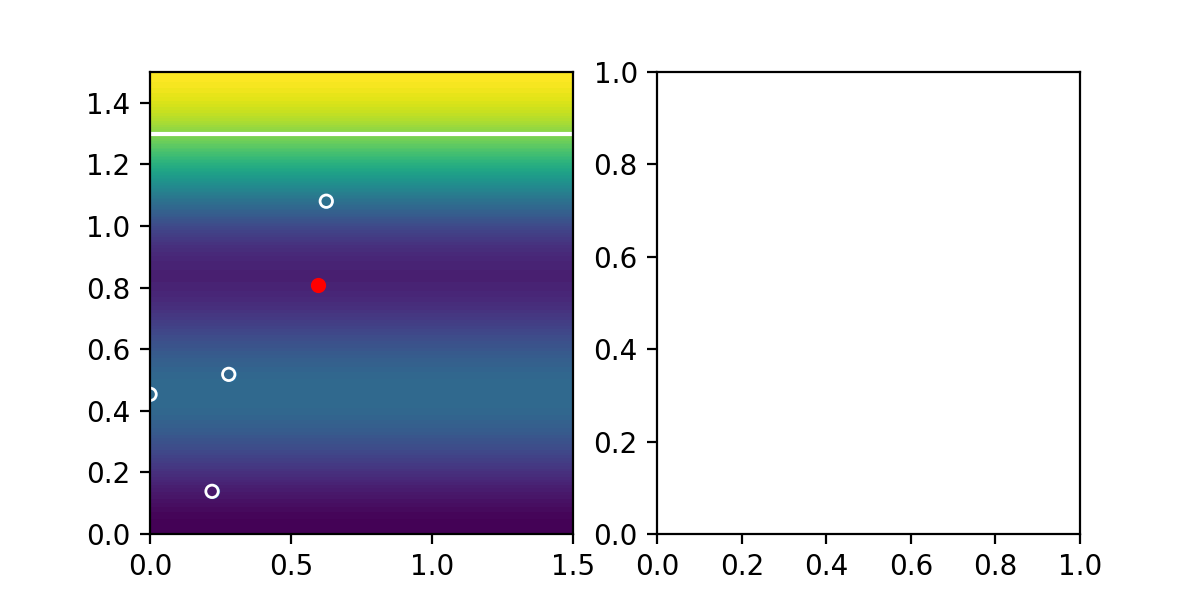

In [108]:
f,axarr = plt.subplots(1,2)
f.set_size_inches(6,3)

f.axes[0].set_ylim(0,1)
f.axes[0].set_xlim(0,1)

f.axes[1].set_ylim(0,1)
f.axes[1].set_xlim(0,1)

ContourBuilder(f, human, algo)
plot_player(f.axes[0],human)